<a href="https://colab.research.google.com/github/sunvod/sormani/blob/master/ACRE_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os

import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

VALIDATION = 0.15

cwd = os.getcwd()
BASE_DIR = os.path.join(cwd, 'drive/MyDrive/Development_Dataset')

IMG_SET = 'Bipbip'
VEG_SET = 'Haricot'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip /content/drive/My\ Drive/SegmentationDataset.zip

# Example: Image Segmentation
## Build segmentation

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    train_img_data_gen = ImageDataGenerator(rotation_range=30,
                                            width_shift_range=10,
                                            height_shift_range=10,
                                            zoom_range=0.3,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            fill_mode='reflect',
                                            validation_split=VALIDATION,
                                            rescale=1./255)
    train_mask_data_gen = ImageDataGenerator(rotation_range=30,
                                             width_shift_range=10,
                                             height_shift_range=10,
                                             zoom_range=0.3,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             validation_split=VALIDATION,
                                             fill_mode='reflect')
else:
    train_img_data_gen = ImageDataGenerator(validation_split=VALIDATION,
                                            rescale=1./255)
    train_mask_data_gen = ImageDataGenerator(validation_split=VALIDATION)

# Create validation and test ImageDataGenerator objects
valid_img_data_gen = ImageDataGenerator(validation_split=VALIDATION,
                                        rescale=1./255)
valid_mask_data_gen = ImageDataGenerator(validation_split=VALIDATION)
test_img_data_gen = ImageDataGenerator(validation_split=VALIDATION,
                                       rescale=1./255)
test_mask_data_gen = ImageDataGenerator(validation_split=VALIDATION)

In [ ]:
# Create generators to read images from dataset directory
# -------------------------------------------------------

# Batch size
bs = 16

# img shape
img_h = 256
img_w = 256
num_classes=3

# Training
# Two different generators for images and masks
# ATTENTION: here the seed is important!! We have to give the same SEED to both the generator
# to apply the same transformations/shuffling to images and corresponding masks
training_dir = os.path.join(BASE_DIR, 'Training', IMG_SET, VEG_SET)
train_img_gen = train_img_data_gen.flow_from_directory(os.path.join(training_dir, 'Images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs,
                                                       classes={''},
                                                       class_mode=None, 
                                                       shuffle=True,
                                                       interpolation='bilinear',
                                                       subset="training",
                                                       seed=SEED)  
train_mask_gen = train_mask_data_gen.flow_from_directory(os.path.join(training_dir, 'Masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs,
                                                         classes={''},
                                                         class_mode=None,
                                                         shuffle=True,
                                                         interpolation='bilinear',
                                                         subset="training",
                                                         seed=SEED)
train_gen = zip(train_img_gen, train_mask_gen)

# Validation
validation_dir = training_dir
valid_img_gen = valid_img_data_gen.flow_from_directory(os.path.join(validation_dir, 'Images'),
                                                       target_size=(img_h, img_w),
                                                       batch_size=bs, 
                                                       classes={''},
                                                       class_mode=None, 
                                                       shuffle=False,
                                                       interpolation='bilinear',
                                                       subset="validation",
                                                       seed=SEED)
valid_mask_gen = valid_mask_data_gen.flow_from_directory(os.path.join(validation_dir, 'Masks'),
                                                         target_size=(img_h, img_w),
                                                         batch_size=bs, 
                                                         classes={''},
                                                         class_mode=None,
                                                         shuffle=False,
                                                         interpolation='bilinear',
                                                         subset="validation",
                                                         seed=SEED)
valid_gen = zip(valid_img_gen, valid_mask_gen)

Found 77 images belonging to 1 classes.
Found 77 images belonging to 1 classes.
Found 13 images belonging to 1 classes.
Found 13 images belonging to 1 classes.


In [ ]:
# Create Dataset objects
# ----------------------

# Training
# --------
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 3]))

# This is needed to convert targets from H x W x 3 (RGB) to label mask H x W x 1.
# Thus, 255 values become True (with y_ > 0), i.e., RGB value [255, 255, 255] -> [True, True, True],
# and then we reduce it to a single value (reduce_any), i.e., RGB value [255, 255, 255] -> [True].
# Finally, cast boolean values to float to obtain 0-1 labels.
def prepare_target(x_, y_):
    return x_, tf.cast(tf.reduce_any(y_ > 0, axis=-1, keepdims=True), tf.float32)

train_dataset = train_dataset.map(prepare_target)

# Repeat
train_dataset = train_dataset.repeat()

# Validation
# ----------
valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, img_h, img_w, 3]))
valid_dataset = valid_dataset.map(prepare_target)

# Repeat
valid_dataset = valid_dataset.repeat()

In [ ]:
iterator = iter(train_dataset)

[0. 1.]


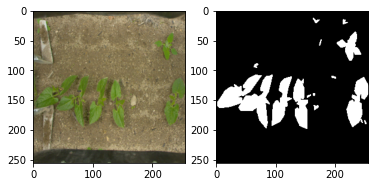

In [ ]:
# Let's test data generator
# -------------------------
import time
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
colors_dict = {}
colors_dict[1] = [255, 255, 255]  # foreground
colors_dict[0] = [0, 0, 0]  # background

iterator = iter(train_dataset)

fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img * 255  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = colors_dict[0]
target_img[np.where(target == 1)] = colors_dict[1]

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Convolutional Neural Network (CNN)
### Encoder-Decoder

In [ ]:
# Create Model
# ------------

def create_model(depth, start_f, num_classes, dynamic_input_shape):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    for i in range(depth):
        
        if i == 0:
            if dynamic_input_shape:
                input_shape = [None, None, 3]
            else:
                input_shape = [img_h, img_w, 3]
        else:
            input_shape=[None]
        
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same',
                                         input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2

    # Bottleneck
    model.add(tf.keras.layers.Conv2D(filters=start_f, kernel_size=(3, 3), strides=(1, 1), padding='same'))
    model.add(tf.keras.layers.ReLU())
    
    start_f = start_f // 2
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=1,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='sigmoid'))
    
    return model

In [ ]:
model = create_model(depth=5, 
                     start_f=8, 
                     num_classes=1, 
                     dynamic_input_shape=False)

# Visualize created model as a table
model.summary()

# Visualize initialized weights
# model.weights

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4

## Prepare the model for training

In [ ]:
# Optimization params
# -------------------

# Loss
# Binary Crossentropy
loss = tf.keras.losses.BinaryCrossentropy() 
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------
score_th = 0.5

def IoU(y_true, y_pred):
    y_pred = tf.cast(y_pred > score_th, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    return intersection / union

metrics = ['accuracy', IoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'binary_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(train_img_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_img_gen), 
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100
5/5 [==============================] - 140s 27s/step - loss: 0.6800 - accuracy: 0.4035 - IoU: 0.0922 - val_loss: 0.3949 - val_accuracy: 0.8915 - val_IoU: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 12s 2s/step - loss: 0.5128 - accuracy: 0.8435 - IoU: 0.0000e+00 - val_loss: 0.4536 - val_accuracy: 0.8915 - val_IoU: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 11s 2s/step - loss: 0.4823 - accuracy: 0.8484 - IoU: 0.0000e+00 - val_loss: 0.3575 - val_accuracy: 0.8915 - val_IoU: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 11s 2s/step - loss: 0.4398 - accuracy: 0.8410 - IoU: 0.0000e+00 - val_loss: 0.3148 - val_accuracy: 0.8915 - val_IoU: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 11s 2s/step - loss: 0.3839 - accuracy: 0.8473 - IoU: 0.0000e+00 - val_loss: 0.2821 - val_accuracy: 0.8915 - val_IoU: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 11s 2s/step - loss: 0.3435 - accuracy: 0.8467 - IoU: 0.0

## Test model

## Compute prediction

In [ ]:
iterator = iter(valid_dataset)

(256, 256)


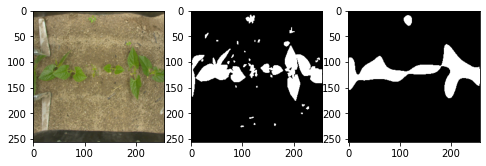

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
predicted_class = predicted_class[0, ..., 0]

print(predicted_class.shape)

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = colors_dict[0]
target_img[np.where(target == 1)] = colors_dict[1]

prediction_img[np.where(predicted_class == 0)] = colors_dict[0]
prediction_img[np.where(predicted_class == 1)] = colors_dict[1]

ax[0].imshow(np.uint8(image*255.))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)